In [140]:
import numpy as np
from numpy import *
import scipy.io
import struct

import csv
import numpy
import ipyvolume as ipv
from scipy import interpolate
#from scipy import special
#import matplotlib
#import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
#from matplotlib import cm
#from matplotlib.ticker import LinearLocator, FormatStrFormatter


In [141]:
#set model constants
ep0=8.854188e-12
c=3.0e8

In [142]:
#set model parameters

def setmodelparams():
    pardict={}
    pardict["nx"]=20
    pardict["ny"]=20

    pardict["xmax"]=1.0
    pardict["xmin"]=-1.0
    pardict["ymax"]=1.0
    pardict["ymin"]=-1.0
    pardict["dt"]=0.1

    pardict["delx"]=(pardict["xmax"]-pardict["xmin"])/pardict["nx"]
    pardict["dely"]=(pardict["ymax"]-pardict["ymin"])/pardict["ny"]
    pardict["nc"]=1 #number of charges
    return pardict

In [143]:
#function to update the electric field and the potential
def updatefields(t,pars,cdat,opotential,oex,oey):
    #extract modelpars from  modelpars
    nx=pars["nx"]
    ny=pars["ny"]
    
    xmax=pars["xmax"]
    xmin=pars["xmin"]
    ymax=pars["ymax"]
    ymin=pars["ymin"]
    
    delx=pars["delx"]
    dely=pars["dely"]
    
    delt=pars["dt"]   #0.1

    #extract chargedat from chargedat
    xp=cdat["xp"]
    yp=cdat["yp"]
    vmag=cdat["vmag"]
    vxp=cdat["vxp"]
    vyp=cdat["vyp"]
    omeg=cdat["omeg"]
    qp=cdat["q"]

    
    for i in range(0,nx-1):
        for j in range(0,ny-1):
            #intiailise potential and field because these are computed for each charge
            fpot=0.0
            #ex=0
            #ey=0
            for ic in range(0,nc):
                #compute field position
                x=xmin+delx*i
                y=ymin+dely*j
                #calculate change in charge position
                dx=delt*vxp[ic]*np.sin(omeg[ic]*t)
                dy=delt*vyp[ic]*np.sin(omeg[ic]*t)
                xp[ic]=xp[ic]+dx
                yp[ic]=yp[ic]+dy
                r12x=x-xp[ic]
                r12y=y-yp[ic]
                r12mag=np.sqrt(r12x*r12x+r12y*r12y)
                # compute component of velocity along field direction i.e. we use the vector dot product
                vrdash=vmag[ic]*(r12x*vxp[ic]+r12y*vyp[ic])/r12mag
                # compute potential
                fpot=fpot+((qp[ic]/r12mag)*(1/(1-vrdash)))
            potential[i,j]=fpot
    
    #compute the fields
    for i in range(0,nx-1):
        for j in range(0,ny-1):        
            #compute gradient (and field using central difference) if boundary assume 0 (charges always in middle of our large grid)
            #
            if i == 0:
                ex[i, j] = (potential[i+1, j]) / delx
            elif i==nx-1:
                ex[i,j]=(-potential[i-1,j])/delx
            else:
                ex[i,j]=(potential[i+1,j]-potential[i-1,j])/delx
                
            if j == 0:
                ey[i,j]=(potential[i,j+1])/dely 
            elif j  == ny-1:   
                ey[i,j]=(-potential[i,j-1])/dely
            else:
                ey[i,j]=(potential[i,j+1]-potential[i,j-1])/dely


    return potential,ex,ey

In [144]:
#modelparams

pars=setmodelparams()
nx=pars["nx"]
ny=pars["ny"]

xmax=pars["xmax"]
xmin=pars["xmin"]
ymax=pars["ymax"]
ymin=pars["ymin"]

delx=pars["delx"]
dely=pars["dely"]

nc=pars["nc"]

delt=pars["dt"]   #0.1

In [145]:
#charge positions
xp=np.zeros(nc)
yp=np.zeros(nc)
vxp=np.zeros(nc)
vyp=np.zeros(nc)
vmag=np.zeros(nc)
omeg=np.zeros(nc)
qp=np.zeros(nc)

#create fields
potential = np.zeros( (nx,ny) ); #scalar potential
ex = np.zeros( (nx,ny) ); # electric field x
ey = np.zeros(  (nx,ny)  ); #electric field y 

In [146]:
#set the charge positions
xp[0]=delx/2   #at cell centre not the grid cell
yp[0]=dely/2

vmag[0]=0.2  #this is in units of c
vyp[0]=np.sin(np.pi/4)
vxp[0]=np.cos(np.pi/4)

omeg[0]=0.5
qp[0]=1.0  #this is the charge divided by 4pi epsilon0



In [147]:
cdat={}
cdat["xp"]=xp
cdat["yp"]=yp
cdat["vmag"]=vmag
cdat["vxp"]=vxp
cdat["vyp"]=vyp
cdat["omeg"]=omeg
cdat["q"]=qp

print(vxp,vyp)

[0.70710678] [0.70710678]


In [148]:
t=0.1
pars=setmodelparams()

cdat["xp"]=xp
cdat["yp"]=yp
cdat["vmag"]=vmag
cdat["vxp"]=vxp
cdat["vyp"]=vyp
cdat["omeg"]=omeg
cdat["q"]=qp

potential,ex,ey=updatefields(t,pars,cdat,potential,ex,ey)

In [150]:
print(potential)

[[ 5.49856462e+00  5.75324019e+00  6.02009821e+00  6.29718401e+00
   6.58137789e+00  6.86812791e+00  7.15124523e+00  7.42285394e+00
   7.67360845e+00  7.89327676e+00  8.07171441e+00  8.20011801e+00
   8.27229577e+00  8.28560914e+00  8.24130213e+00  8.14413337e+00
   8.00146110e+00  7.82207882e+00  7.61510410e+00  0.00000000e+00]
 [-1.95292138e-01 -1.92119764e-01 -1.83948041e-01 -1.69218618e-01
  -1.46177611e-01 -1.13016021e-01 -6.81251314e-02 -1.04783649e-02
   5.98961106e-02  1.41461359e-01  2.30917317e-01  3.23339802e-01
   4.12805761e-01  4.93394185e-01  5.60253480e-01  6.10372680e-01
   6.42833449e-01  6.58556475e-01  6.59737295e-01  0.00000000e+00]
 [-2.06266651e-01 -2.06976855e-01 -2.03577008e-01 -1.94561303e-01
  -1.78125375e-01 -1.52236853e-01 -1.14813318e-01 -6.40465035e-02
   1.11629006e-03  8.03890251e-02  1.71617240e-01  2.70544850e-01
   3.71113206e-01  4.66361218e-01  5.49712365e-01  6.16208079e-01
   6.63253010e-01  6.90682728e-01  7.00271624e-01  0.00000000e+00]
 [-2.14

-1.0 1.0 0.1 (21,) (20, 20)


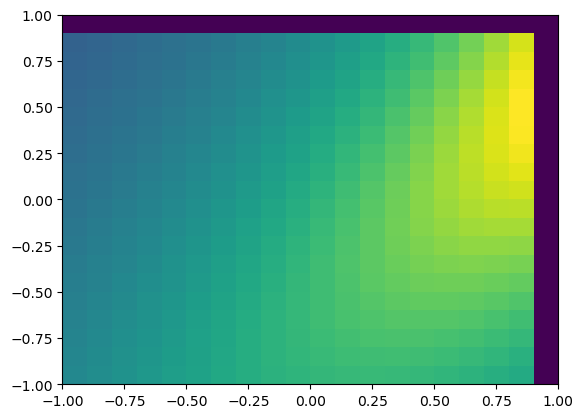

In [136]:
fig, ax = plt.subplots()
Z=potential
x=np.arange(start=xmin, stop=xmax+delx, step=delx)
y=np.arange(start=ymin, stop=ymax+dely, step=dely)

print(xmin,xmax,delx,np.shape(x),np.shape(Z))
s=ax.pcolormesh(x, y, Z, shading='flat', vmin=Z.min(), vmax=Z.max())

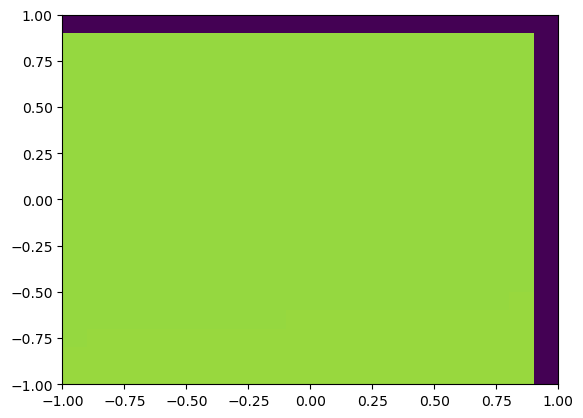

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

dt=0.1
fig, ax = plt.subplots()
Z=potential
x=np.arange(start=xmin, stop=xmax+delx, step=delx)
y=np.arange(start=ymin, stop=ymax+dely, step=dely)

#global s
s =ax.pcolormesh(x, y, Z, shading='flat', vmin=Z.min(), vmax=Z.max())

#def init():  # only required for blitting to give a clean slate.
#    global s
#    potential,ex,ey=updatefields(0,pars,cdat,potential,ex,ey)   
#    s.set_array(potential.ravel())  # use set_array for pcolormesh!
#    #s.set_zdata(potential)
#    return s,

#state = {"potential": potential, "ex": ex, "ey": ey}




def animate(i, s):
    global potential, ex, ey
    potential, ex, ey = updatefields(i * dt, pars, cdat, potential, ex, ey)
    s.set_array(potential.ravel())
    return s,


#ani = animation.FuncAnimation(fig, animate, fargs=(s, state), interval=2, blit=True, save_count=50)
ani = animation.FuncAnimation(fig, animate, fargs=(s,), interval=2, blit=True, save_count=50)







HTML(ani.to_jshtml())


In [99]:
# f(u, v) -> (u, v, u*v**2)

Z=potential
x=np.arange(start=xmin, stop=xmax+delx, step=delx)
y=np.arange(start=ymin, stop=ymax+dely, step=dely)
#a = np.arange(-5, 5)
U, V = np.meshgrid(x, y)
X = U
Y = V
#Z = X*Y**2

ipv.figure()
ipv.plot_surface(X, Z, Y, color="orange")
ipv.plot_wireframe(X, Z, Y, color="red")
ipv.show()

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…